<a href="https://colab.research.google.com/github/OvaTech-AI/pcos_cnn_diagnosis/blob/main/PCOS_CNN_Erika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torch torchvision matplotlib scikit-learn

In [ ]:
import os
import numpy as np
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from PIL import Image
import copy, random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip Team_CNN_Ultrasound_data.zip -d /content/unzipped_files

In [ ]:
# Define the paths
data_dir = '/content/unzipped_files/Team_CNN_Ultrasound_data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# Define the transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create the datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(train_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Print the class to index mapping to inspect
print("Class to index mapping:", image_datasets['train'].class_to_idx)

# Split the train dataset into train and validation sets
train_size = int(0.85 * len(image_datasets['train']))
val_size = len(image_datasets['train']) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_datasets['train'], [train_size, val_size])

# Create the DataLoader
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=True),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
}

# Get dataset sizes and class names
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(image_datasets['test'])}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Class to index mapping: {'infected': 0, 'notinfected': 1}
Dataset sizes: {'train': 1635, 'val': 289, 'test': 1932}
Class names: ['infected', 'notinfected']


In [ ]:
def get_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []

    for label in ['infected', 'notinfected']:
        label_dir = os.path.join(root_dir, label)
        for root, _, files in os.walk(label_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(root, file)
                    try:
                        # Attempt to open the image to check for corruption
                        Image.open(image_path).convert("RGB")
                        image_paths.append(image_path)
                        labels.append(0 if label == 'infected' else 1)
                    except Exception as e:
                        print(f"Skipping corrupted image: {image_path}")

    return image_paths, labels

# Define the paths for train and test datasets
train_root_dir = '/content/unzipped_files/Team_CNN_Ultrasound_data/train'
test_root_dir = '/content/unzipped_files/Team_CNN_Ultrasound_data/test'

# Get image paths and labels for train and test datasets
train_image_paths, train_labels = get_image_paths_and_labels(train_root_dir)
test_image_paths, test_labels = get_image_paths_and_labels(test_root_dir)

# Print the number of images and a sample path to verify
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of testing images: {len(test_image_paths)}")
print(f"Number of labels of training images: {len(train_labels)}")
print(f"Number of labels of testing images: {len(test_labels)}")
print(f"Sample train image path: {train_image_paths[0]}")
print(f"Sample test image path: {test_image_paths[0]}")

Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/infected/WhatsApp Image 2022-04-01 at 3.50.20 PM.jpeg
Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/infected/OIP.jpg
Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/infected/WhatsApp Image 2022-04-01 at 3.49.22 PM.jpeg
Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/infected/WhatsApp Image 2022-04-01 at 3.50.05 PM.jpeg
Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/infected/R.jpg
Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/infected/WhatsApp Image 2022-04-01 at 3.49.45 PM.jpeg
Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/notinfected/WhatsApp Image 2022-04-01 at 3.35.25 PM.jpeg
Skipping corrupted image: /content/unzipped_files/Team_CNN_Ultrasound_data/test/notinfected/WhatsApp Image 2022-04-01 at 3.39.07 PM.jpe

In [ ]:
infected_test_images = 0
for i in range(len(test_labels)):
  label = test_labels[i]
  if label == 0:
    infected_test_images += 1
print(f"Number of infected images in test folder: {infected_test_images}")
print(f"Number of notinfected images in test folder: {len(test_labels) - infected_test_images}")

Number of infected images in test folder: 781
Number of notinfected images in test folder: 1141


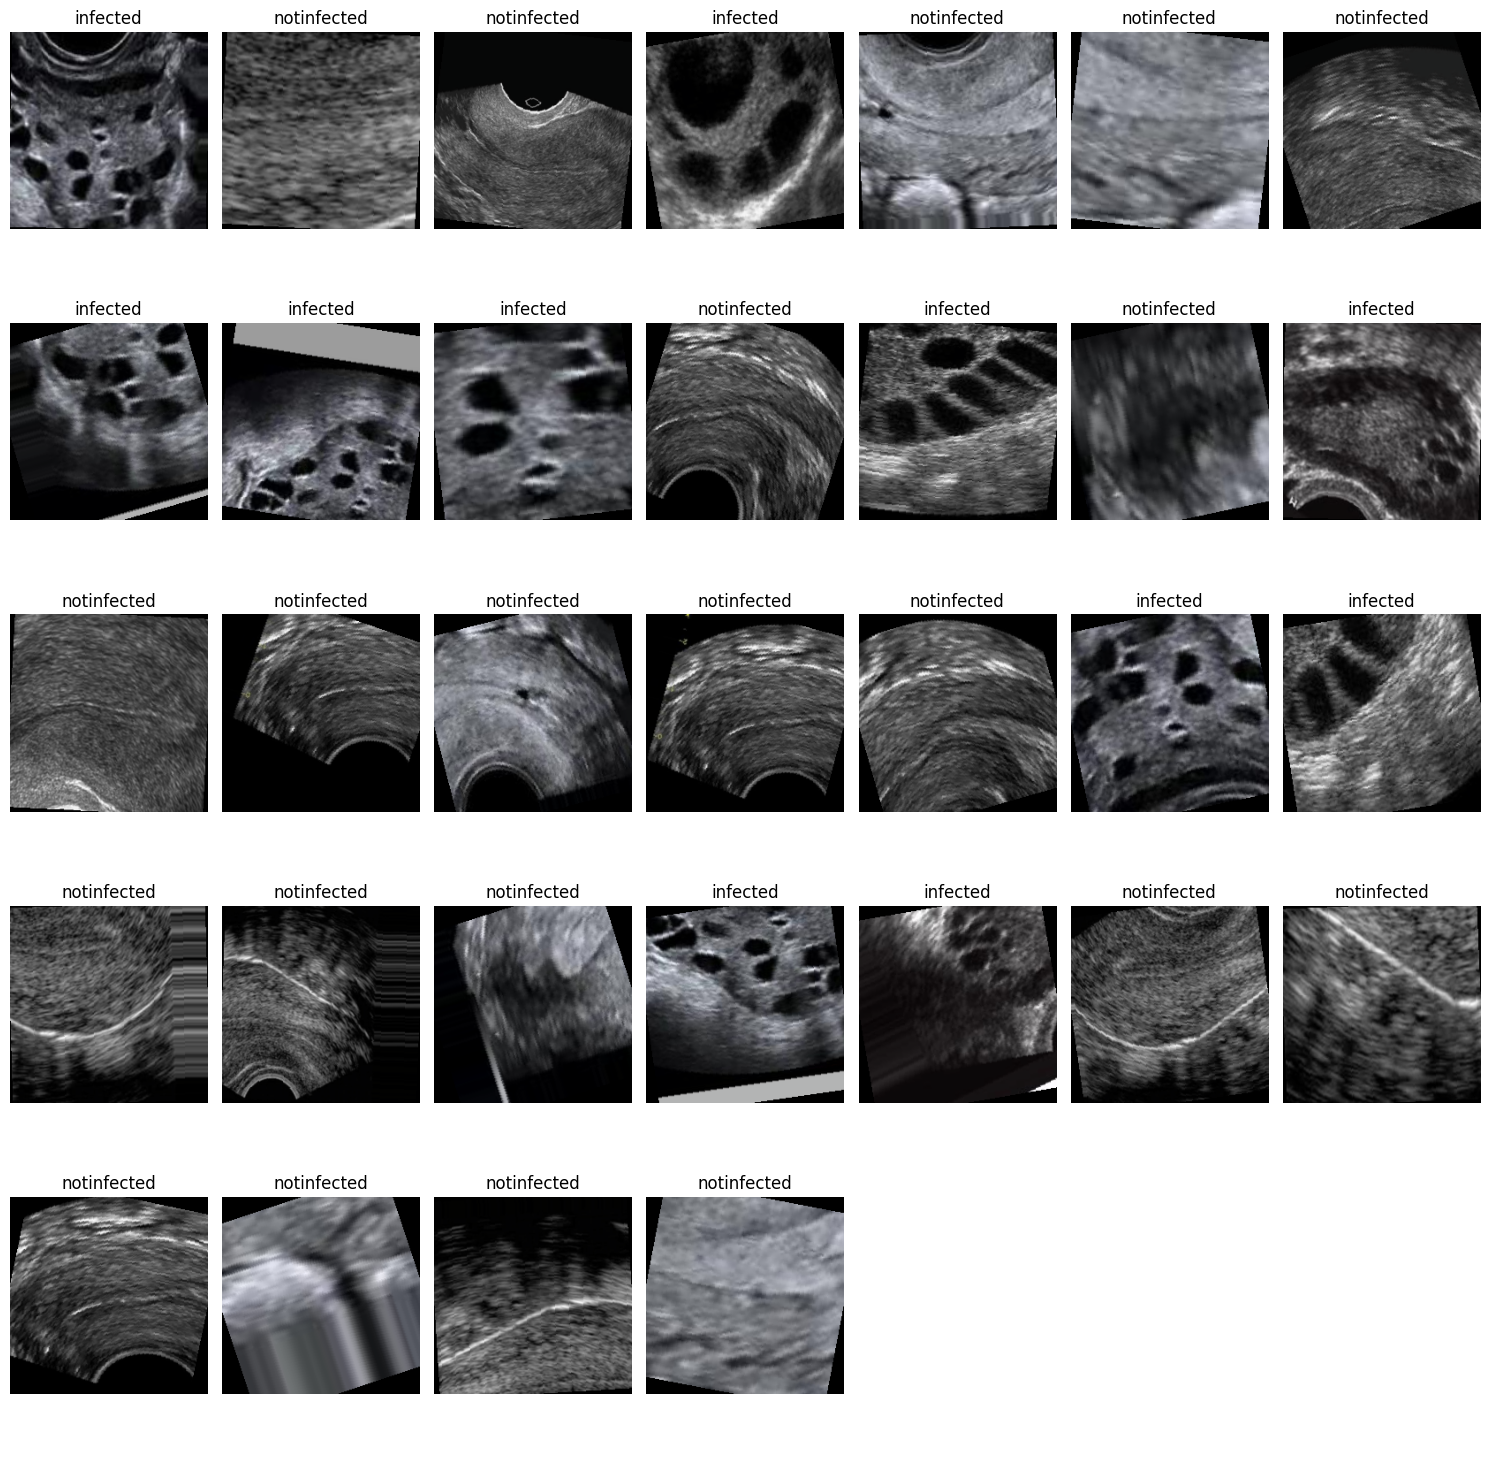

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Number of images to show
num_images = len(inputs)
rows = int(np.sqrt(num_images))
cols = (num_images // rows) + (num_images % rows > 0)

# Set up the figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Plot each image with its label
for idx, ax in enumerate(axes.flat):
    if idx < num_images:
        img = imshow(inputs[idx])
        ax.imshow(img)
        ax.set_title(class_names[classes[idx]])
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 8, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=5, padding=2)

        # Compute the size of the feature map after the conv and pool layers
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))
        self.fc1 = nn.Linear(self._to_linear, 1)

    def convs(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        if self._to_linear is None:
            self._to_linear = x.view(-1).size(0)
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc1(x)
        return x

model = CNNModel()

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=20):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.float().to(device).unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                preds = torch.round(torch.sigmoid(outputs))
                running_corrects += torch.sum(preds == labels.data)

               # Visualize a few samples from the batch
                # if phase == 'train' and epoch == 0:  # Only visualize during the first epoch
                #     sample_idx = random.randint(0, len(inputs) - 1)  # Random index of the sample to plot
                #     visualize_sample(inputs[sample_idx].cpu(), labels[sample_idx].item(), preds[sample_idx].item())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print(f'{dataset_sizes[phase]}')
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, history

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Putting the below two line before train_model() was one issue
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6774 Acc: 0.5835
val Loss: 0.6656 Acc: 0.7163
Epoch 1/19
----------
train Loss: 0.6128 Acc: 0.6636
val Loss: 0.4450 Acc: 0.7924
Epoch 2/19
----------
train Loss: 0.3863 Acc: 0.8263
val Loss: 0.7830 Acc: 0.6713
Epoch 3/19
----------
train Loss: 0.4228 Acc: 0.8214
val Loss: 0.4125 Acc: 0.8062
Epoch 4/19
----------
train Loss: 0.2816 Acc: 0.8856
val Loss: 0.3156 Acc: 0.8616
Epoch 5/19
----------
train Loss: 0.2885 Acc: 0.8826
val Loss: 0.3243 Acc: 0.8720
Epoch 6/19
----------
train Loss: 0.2512 Acc: 0.8997
val Loss: 0.2735 Acc: 0.8927
Epoch 7/19
----------
train Loss: 0.2355 Acc: 0.9119
val Loss: 0.2015 Acc: 0.9170
Epoch 8/19
----------
train Loss: 0.2051 Acc: 0.9199
val Loss: 0.2115 Acc: 0.9204
Epoch 9/19
----------
train Loss: 0.2065 Acc: 0.9174
val Loss: 0.1963 Acc: 0.9204
Epoch 10/19
----------
train Loss: 0.1673 Acc: 0.9327
val Loss: 0.3766 Acc: 0.8339
Epoch 11/19
----------
train Loss: 0.1977 Acc: 0.9162
val Loss: 0.2243 Acc: 0.9204
Epoch 12/19
--

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Define the custom test dataset
test_dataset = CustomDataset(test_image_paths, test_labels, transform=data_transforms['test'])

# Create the DataLoader for the custom test dataset
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.float().to(device).unsqueeze(1)
            outputs = model(inputs)

            preds = torch.round(torch.sigmoid(outputs))

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Debugging prints for each batch
            # print(f'Batch Labels: {labels.cpu().numpy().flatten()}')
            # print(f'Batch Predictions: {preds.cpu().numpy().flatten()}')

            # Visualize a sample from the batch
            # visualize_sample(inputs[0].cpu(), labels[0].item(), preds[0].item())

    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix')
    print(cm)

trained_model, training_history = model
evaluate_model(trained_model, test_dataloader)

              precision    recall  f1-score   support

    infected       0.98      1.00      0.99       781
 notinfected       1.00      0.99      0.99      1141

    accuracy                           0.99      1922
   macro avg       0.99      0.99      0.99      1922
weighted avg       0.99      0.99      0.99      1922

Confusion Matrix
[[ 781    0]
 [  16 1125]]


In [ ]:
# Another way to evalute the metrics
def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    tp, fp, tn, fn = 0, 0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.float().to(device).unsqueeze(1)
            outputs = model(inputs)

            preds = torch.round(torch.sigmoid(outputs))
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate running corrects
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

            # Calculate tp, fp, tn, fn
            for i in range(len(labels)):
                if labels[i] == 1 and preds[i] == 1:
                    tp += 1
                elif labels[i] == 0 and preds[i] == 1:
                    fp += 1
                elif labels[i] == 0 and preds[i] == 0:
                    tn += 1
                elif labels[i] == 1 and preds[i] == 0:
                    fn += 1

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Precision: {precision:.4f} Recall: {recall:.4f} F1-Score: {f1_score:.4f}')
    print(f'True Positives: {tp}, False Positives: {fp}, True Negatives: {tn}, False Negatives: {fn}')

    return {
        'loss': epoch_loss,
        'accuracy': epoch_acc.item(),
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn
    }

results = evaluate_model(trained_model, test_dataloader)

Test Loss: 0.0263 Acc: 0.9917
Precision: 1.0000 Recall: 0.9860 F1-Score: 0.9929
True Positives: 1125, False Positives: 0, True Negatives: 781, False Negatives: 16


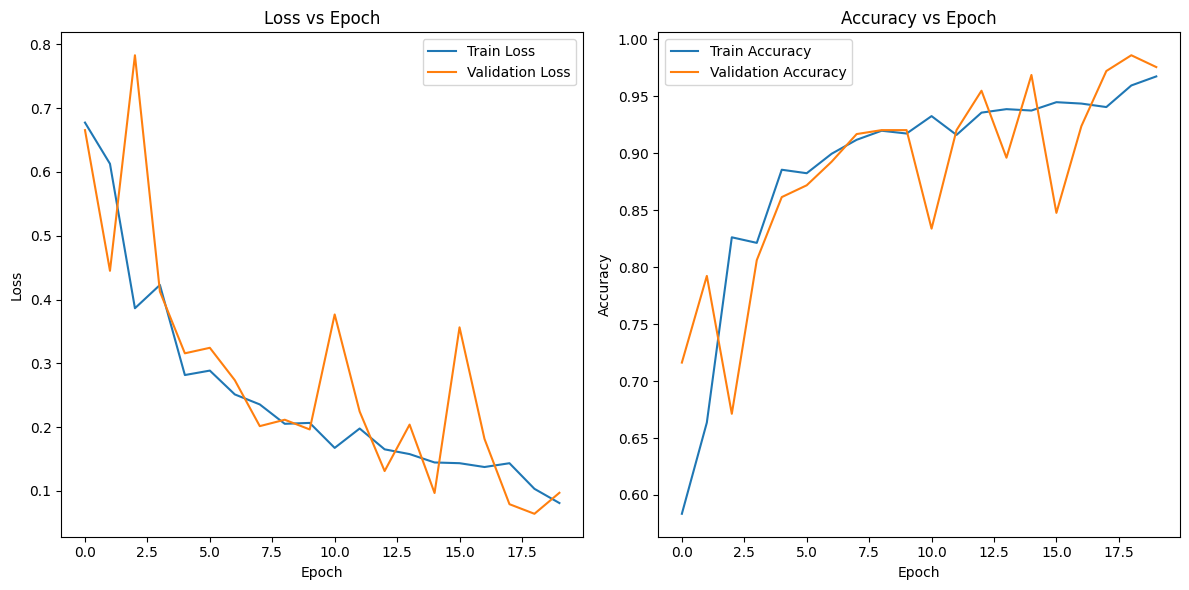

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot for loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    # Plot for accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(training_history)

In [ ]:
from google.colab import drive
import shutil
import os

drive.mount('/content/drive')

Mounted at /content/drive
